#  Potencial de técnicas de NLP

In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

import os
from termcolor import colored
import tqdm
import scipy
import gc
import joblib

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab

pylab.rcParams['figure.figsize'] = 6, 4

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Cargar los datos desde el archivo JSON
#data_path = '/content/drive/My Drive/proyecto/full_format_recipes.json'  # Clara
data_path = '/content/drive/My Drive/Colab Notebooks/proyecto/full_format_recipes.json'  # Jorge
recipes_df = pd.read_json(data_path)

Mounted at /content/drive


#ANÁLISIS DE BIGRAMAS

In [ ]:
target = recipes_df['rating']#variable de salida

# Extracción de las características y variables objetivo
text_features = recipes_df[['desc', 'directions','title']]
categories=recipes_df['categories']
numeric_features = recipes_df[['fat', 'protein', 'calories', 'sodium','date']]

##Preprocesado

In [ ]:
import re
import nltk

def check_nltk_packages():
  packages = ['punkt','stopwords','omw-1.4','wordnet']

  for package in packages:
    try:
      nltk.data.find('tokenizers/' + package)
    except LookupError:
      nltk.download(package)
check_nltk_packages()

try:
  import lxml
except ModuleNotFoundError:
  %pip install lxml

try:
  import contractions
except ModuleNotFoundError:
  %pip install contractions
  import contractions

from bs4 import BeautifulSoup
import re

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data] Downloading package wordnet to /root/nltk_data...


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 9.0 MB/s eta 0:00:00


#### **2.1 Wrangling**

In [ ]:
def wrangle_text(text):
    # Asegurarnos de que sea una cadena
    text = str(text)

    # Eliminamos las comas, guiones, puntos y números
    text = re.sub(r',', '', text)
    text = re.sub(r'-', '', text)
    text = re.sub(r'\.', '', text)
    text = re.sub(r'\d+', '', text)
    return re.sub(r"[^a-zA-Z\s]", "", text)

# Datos sin wrangling
print('\n====================================== Original ======================================')
print(recipes_df[['directions', 'desc']].head())

# Datos con wrangling
print('\n====================================== Con wrangling ======================================')

recipes_df['p_directions'] = recipes_df['directions'].apply(wrangle_text)
recipes_df['p_desc'] = recipes_df['desc'].apply(wrangle_text)

print(recipes_df[['p_directions', 'p_desc']].head())


====================================== Original ======================================
                                          directions  \
0  [1. Place the stock, lentils, celery, carrot, ...   
1  [Combine first 9 ingredients in heavy medium s...   
2  [In a large heavy saucepan cook diced fennel a...   
3  [Heat oil in heavy large skillet over medium-h...   
4  [Preheat oven to 350°F. Lightly grease 8x8x2-i...   

                                                desc  
0                                               None  
1  This uses the same ingredients found in boudin...  
2                                               None  
3  The Sicilian-style tomato sauce has tons of Me...  
4                                               None  

====================================== Con wrangling ======================================
                                        p_directions  \
0   Place the stock lentils celery carrot thyme a...   
1  Combine first  ingredients in heavy m

#### **2.2 Tokenization**

In [ ]:
from nltk.tokenize import wordpunct_tokenize
from nltk.tokenize import sent_tokenize
import nltk
nltk.download('punkt_tab')

print('\n====================================== Original ======================================')
print(recipes_df[['directions', 'desc']].head())

def tokenize_text(text):
  review_tokens_sent = []
  for sent in sent_tokenize(text):
    sentence_tokens = wordpunct_tokenize(sent)
    review_tokens_sent.append(sentence_tokens)

  return review_tokens_sent

# Applicar función a vector direcciones y descripción
recipes_df['tokens_directions'] = recipes_df['p_directions'].apply(tokenize_text)
recipes_df['tokens_desc'] = recipes_df['p_desc'].apply(tokenize_text)

print('\n====================================== Con tokenización ======================================')
print(recipes_df[['tokens_directions', 'tokens_desc']].head())

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!



====================================== Original ======================================
                                          directions  \
0  [1. Place the stock, lentils, celery, carrot, ...   
1  [Combine first 9 ingredients in heavy medium s...   
2  [In a large heavy saucepan cook diced fennel a...   
3  [Heat oil in heavy large skillet over medium-h...   
4  [Preheat oven to 350°F. Lightly grease 8x8x2-i...   

                                                desc  
0                                               None  
1  This uses the same ingredients found in boudin...  
2                                               None  
3  The Sicilian-style tomato sauce has tons of Me...  
4                                               None  

====================================== Con tokenización ======================================
                                   tokens_directions  \
0  [[Place, the, stock, lentils, celery, carrot, ...   
1  [[Combine, first, ingredients, in,

#### **2.3 Homogenization**

In [ ]:
#Se queda solo con caracteres alfanumericos y los pasa a minuscula
def filter_tokens(tokens):

  filtered_tokens_list = []
  tokens_list = tokens
  for tokens in tokens_list: # Iterate over each sentence's tokens
    tokens_filtered = [token.lower() for token in tokens if token.isalnum()]
    filtered_tokens_list.extend(tokens_filtered)

  return filtered_tokens_list

recipes_df['filtered_directions'] = recipes_df['tokens_directions'].apply(filter_tokens)
recipes_df['filtered_desc'] = recipes_df['tokens_desc'].apply(filter_tokens)

print('\n====================================== Original ======================================')
print(recipes_df[['directions', 'desc']].head())

print('\n====================================== Con filtrado ======================================')
print(recipes_df[['filtered_directions', 'filtered_desc']].head())


====================================== Original ======================================
                                          directions  \
0  [1. Place the stock, lentils, celery, carrot, ...   
1  [Combine first 9 ingredients in heavy medium s...   
2  [In a large heavy saucepan cook diced fennel a...   
3  [Heat oil in heavy large skillet over medium-h...   
4  [Preheat oven to 350°F. Lightly grease 8x8x2-i...   

                                                desc  
0                                               None  
1  This uses the same ingredients found in boudin...  
2                                               None  
3  The Sicilian-style tomato sauce has tons of Me...  
4                                               None  

====================================== Con filtrado ======================================
                                 filtered_directions  \
0  [place, the, stock, lentils, celery, carrot, t...   
1  [combine, first, ingredients, in, heav

In [ ]:
from nltk.stem import WordNetLemmatizer

# Inicializar el lematizador
wnl = WordNetLemmatizer()

# Función para aplicar la lematización
def lemmatize(tokens):
    """Applies lemmatization to a list of tokens."""
    return [wnl.lemmatize(token) for token in tokens]

# Aplicar lematización a las columnas de tokens filtrados
recipes_df['l_directions'] = recipes_df['filtered_directions'].apply(lemmatize)
recipes_df['l_desc'] = recipes_df['filtered_desc'].apply(lemmatize)

#### **2.4 Cleaning**




In [ ]:
from nltk.corpus import stopwords
stopwords_en = stopwords.words('english')

#Quitar palabras básicas

def cleaning(tokens):
  """Removes stop words from a list of tokens."""
  clean_tokens = [token for token in tokens if token not in stopwords_en]
  return clean_tokens

# Hacemos cleaning de la versión lemmatized
recipes_df['clean_directions'] = recipes_df['l_directions'].apply(cleaning)
recipes_df['clean_desc'] = recipes_df['l_desc'].apply(cleaning)

In [ ]:
print(recipes_df['clean_directions'].head())
print(recipes_df['clean_desc'].head())

0    [place, stock, lentil, celery, carrot, thyme, ...
1    [combine, first, ingredient, heavy, medium, sa...
2    [large, heavy, saucepan, cook, diced, fennel, ...
3    [heat, oil, heavy, large, skillet, mediumhigh,...
4    [preheat, oven, f, lightly, grease, xxinch, gl...
Name: clean_directions, dtype: object
0                                               [none]
1    [us, ingredient, found, boudin, blanc, classic...
2                                               [none]
3    [sicilianstyle, tomato, sauce, ha, ton, medite...
4                                               [none]
Name: clean_desc, dtype: object


aplicación bigrama

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

recipes_df['clean_directions'] = recipes_df['clean_directions'].apply(lambda x: ' '.join(x))
# Crear el vectorizador de bigramas
vectorizer = CountVectorizer(ngram_range=(2, 2), max_df=0.95, min_df=2)

# Aplicar el vectorizador
X_bigram = vectorizer.fit_transform(recipes_df['clean_directions'])

# Convertir la matriz dispersa a un DataFrame para inspeccionarlo
bigram_df = pd.DataFrame(X_bigram.toarray(), columns=vectorizer.get_feature_names_out())

# Imprimir las primeras filas
print(bigram_df.head())

   able see  able tell  absorb additional  absorb almost  absorb custard  \
0         0          0                  0              0               0   
1         0          0                  0              0               0   
2         0          0                  0              0               0   
3         0          0                  0              0               0   
4         0          0                  0              0               0   

   absorb excess  absorb fat  absorb liquid  absorb moisture  absorb much  \
0              0           0              0                0            0   
1              0           0              0                0            0   
2              0           0              0                0            0   
3              0           0              0                0            0   
4              0           0              0                0            0   

   ...  zucchini time  zucchini tomato  zucchini top  zucchini toss  \
0  ...   

In [ ]:
#matriz con todo ceros por que las combinaciones de bigramas en tus textos no son muy frecuentes.

In [ ]:
# Convertir cada lista de palabras en la columna 'clean_desc' a una cadena de texto
recipes_df['clean_desc'] = recipes_df['clean_desc'].apply(lambda x: ' '.join(x))

# Ahora aplica la vectorización de bigramas
vectorizer = CountVectorizer(ngram_range=(2, 2), max_df=0.95, min_df=2)
X_bigram_desc = vectorizer.fit_transform(recipes_df['clean_desc'])

# Convertir la matriz dispersa a un DataFrame
bigram_desc_df = pd.DataFrame(X_bigram_desc.toarray(), columns=vectorizer.get_feature_names_out())

# Mostrar las primeras filas del DataFrame de bigramas
print(bigram_desc_df.head())


   aa parmesan  aaturkey sherry  abandon dinner  abandon favor  abita spring  \
0            0                0               0              0             0   
1            0                0               0              0             0   
2            0                0               0              0             0   
3            0                0               0              0             0   
4            0                0               0              0             0   

   able come  able deny  able find  abreu cabrera  absence spice  ...  \
0          0          0          0              0              0  ...   
1          0          0          0              0              0  ...   
2          0          0          0              0              0  ...   
3          0          0          0              0              0  ...   
4          0          0          0              0              0  ...   

   zucchini dish  zucchini make  zucchini onion  zucchini red  \
0              

## Tesauros


In [ ]:
from nltk.corpus import wordnet as wn

# Asegúrate de tener los datos de WordNet descargados
nltk.download('wordnet')

# Obtener sinónimos de una palabra
synonyms = []
for syn in wn.synsets("happy"):
    for lemma in syn.lemmas():
        synonyms.append(lemma.name())  # Añadir sinónimos a la lista

print(set(synonyms))  # Convertir a conjunto para eliminar duplicados

{'felicitous', 'happy', 'glad', 'well-chosen'}


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [ ]:
import nltk
from nltk.corpus import wordnet as wn
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords

# Descargar los recursos necesarios
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')

# Función para obtener sinónimos usando WordNet
def get_synonyms(word):
    return list({lemma.name() for syn in wn.synsets(word) for lemma in syn.lemmas()})

# Función para reemplazar palabras con sus sinónimos
def replace_with_synonyms(text):
    stop_words = set(stopwords.words('english'))
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word.lower() not in stop_words]

    return ' '.join(
        get_synonyms(word)[0] if get_synonyms(word) else word for word in filtered_tokens
    )

# Aplicar la función a la columna de 'clean_directions'
recipes_df['expanded_directions'] = recipes_df['clean_directions'].apply(replace_with_synonyms)

print(recipes_df[['clean_directions', 'expanded_directions']].head())

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


                                    clean_directions  \
0  place stock lentil celery carrot thyme salt me...   
1  combine first ingredient heavy medium saucepan...   
2  large heavy saucepan cook diced fennel onion b...   
3  heat oil heavy large skillet mediumhigh heat a...   
4  preheat oven f lightly grease xxinch glass bak...   

                                 expanded_directions  
0  plaza well-worn lentil_plant cultivated_celery...  
1  aggregate first-class_honours_degree factor de...  
2  orotund dense saucepan James_Cook dice finocch...  
3  stir_up crude dense orotund frypan mediumhigh ...  
4  preheat oven F light grunge xxinch chalk bakin...  


# Impacto en modelos de usar sinónimos (tesauros)

## representación vectorial con TF-IDF:

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer

recipes_df['text'] = recipes_df['expanded_directions'].astype(str)

# 1. Creamos el vectorizador TF-IDF
tfidf = TfidfVectorizer(
    # Solo incluye términos que aparecen en al menos 5 documentos. Así se eliminan
    # palabras muy raras que no son informativas

    min_df=5,
    # Solo incluye términos que aparecen en un máximo del 80% de los documentos.
    # Así se eliminan palabras muy comunes que probablemente no sean muy descriptivas (explicar informe, distinto)
    max_df=0.8,
)

# 2. Adaptamos el vectorizador a nuestros datos
tfidf.fit(recipes_df['text'])

# 3. Transformamos los datos a matriz de vectores TF-IDF.
# Cada fila es una receta y cada columna una palabra del vocabulario.
# La misma palabra puede tener diferentes puntuaciones TF-IDF en diferentes filas (recetas) de la matriz.

recipes_tfidf = tfidf.transform(recipes_df['text'])

## entrenamiento con random Forest

In [ ]:
%matplotlib inline

import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_curve, auc

import os
from termcolor import colored
import tqdm
import scipy
import gc
import joblib

import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import pylab

pylab.rcParams['figure.figsize'] = 6, 4

### **1. Preparación de los datos de entrenamiento y de test**

In [ ]:
from re import X
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

target = recipes_df['rating']
print(min(target)) #0
print(max(target)) #5
target = target.fillna(target.mean()) # Relleno los valores que faltan (NaN) con media

# Dividimos los datos en conjunto de entrenamiento y de test, features (X) y labels (y)

X_train, X_test, y_train, y_test = train_test_split(recipes_tfidf, target, test_size=0.2, random_state=42)

# Reducir el tamaño del conjunto de datos
sample_size = 2000  # Número de muestras
X_train_sampled, _, y_train_sampled, _ = train_test_split(X_train, y_train, train_size=sample_size, random_state=42)

0.0
5.0


### **2. Entrenamiento y evaluación**

In [ ]:
#para que sea más eficiente por la cantidad de datos de entrenamiento
#SelectKBest es una técnica que selecciona las K mejores características de un conjunto de características según un criterio de evaluación. En este caso "f-regression"

from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

n_components = 500  # Número de componentes principales que quieres conservar
k_best = SelectKBest(f_regression, k=n_components)  # Selecciona las 500 mejores características

In [ ]:
# 1. Selección supervisada (SelectKBest)
k_best = SelectKBest(f_regression, k=n_components)
X_train_selected = k_best.fit_transform(X_train, y_train)
X_test_selected = k_best.transform(X_test)

# Entrenar modelos
model_kbest = RandomForestRegressor(n_estimators=50, random_state=42, n_jobs=-1)

# Ajustar modelos
model_kbest.fit(X_train_selected, y_train)

# Predicciones
y_pred_kbest = model_kbest.predict(X_test_selected)

# Evaluación
mse_kbest = mean_squared_error(y_test, y_pred_kbest)
r2_kbest = r2_score(y_test, y_pred_kbest)

print("Resultados con SelectKBest:")
print(f"Mean Squared Error (MSE): {mse_kbest:.4f}")
print(f"R^2 Score: {r2_kbest:.4f}")

Resultados con SelectKBest:
Mean Squared Error (MSE): 1.4393
R^2 Score: 0.2024


La expansión con sinónimos genera una ligera mejora en el modelo, aunque el impacto es modesto.La mejora no es dramática, probablemente porque los sinónimos no siempre son contextualmente relevantes.

## regresor kNN

/usr/local/lib/python3.10/dist-packages/numpy/ma/core.py:2820: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


Mejor valor de k: 28


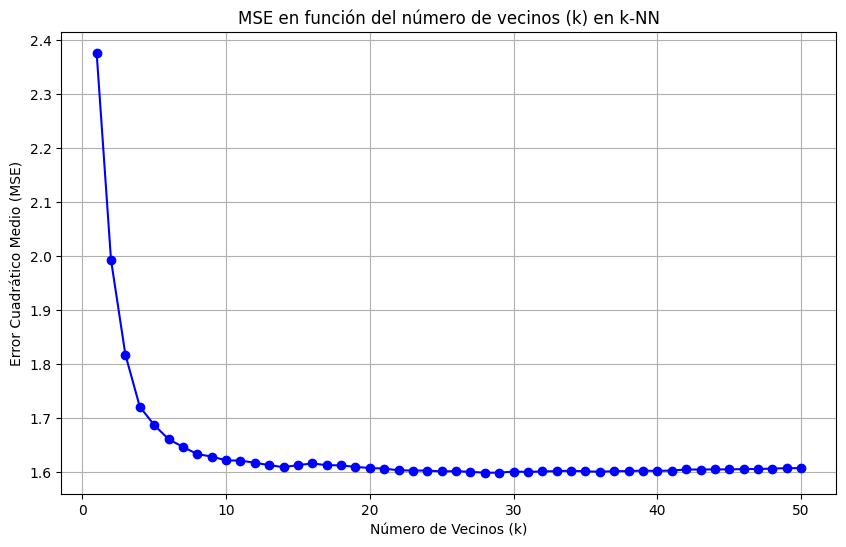

Mean Squared Error con el mejor k (28): 1.6181534798303367
R-squared con el mejor k (28): 0.10328782177900608


In [ ]:
from sklearn.model_selection import train_test_split, KFold, GridSearchCV
from sklearn.neighbors import KNeighborsRegressor
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt

# Seleccionamos las mejores características (1000 características)
# Es recomendable normalizar las características antes de entrenar un modelo k-NN, ya que la métrica
# de distancia utilizada por k-NN se ve afectada por las escalas de las variables.

k_best = SelectKBest(f_regression, k=1000)  # Seleccionamos las 1000 mejores características, con 10000 veíamos un peor MSE overfitting
#tiene sentido ya que estamso sobreajustando demasiado y hay muchas características que estan muy correladas con otras

X_train_selected = k_best.fit_transform(X_train, y_train)
X_test_selected = k_best.transform(X_test)

# Definimos el rango de valores de k a probar
k_values = range(1, 51)  #un valor muy grande puede llevar a undefitting

# Creamos el modelo de k-NN
knn = KNeighborsRegressor()

# Definir los parámetros a buscar
param_grid = {'n_neighbors': k_values}

# Usar GridSearchCV para encontrar el mejor valor de k
grid_search = GridSearchCV(estimator=knn, param_grid=param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search.fit(X_train_selected, y_train)

# Imprimir el mejor valor de k
print(f"Mejor valor de k: {grid_search.best_params_['n_neighbors']}")

# Obtener los resultados de la búsqueda para visualizar
results = grid_search.cv_results_

# Graficar la MSE para cada valor de k
plt.figure(figsize=(10, 6))
plt.plot(k_values, -results['mean_test_score'], marker='o', color='b', label="MSE")
plt.xlabel('Número de Vecinos (k)')
plt.ylabel('Error Cuadrático Medio (MSE)')
plt.title('MSE en función del número de vecinos (k) en k-NN')
plt.grid(True)
plt.show()

# Entrenar el modelo k-NN con el mejor valor de k
best_k = grid_search.best_params_['n_neighbors']
model = KNeighborsRegressor(n_neighbors=best_k)
model.fit(X_train_selected, y_train)

# Predicciones y evaluación
y_pred = model.predict(X_test_selected)

# Evaluar rendimiento
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error con el mejor k ({best_k}):", mse)
print(f"R-squared con el mejor k ({best_k}):", r2)